In [1]:
# import libraries
import csv
import re, string
import numpy as np
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pickle
from gensim.test.utils import datapath
from collections import Counter

In [2]:
# read in data
with open('ratemd.25k.all.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)
    f.close()

### Task 1

#### Read in Data

In [3]:
doctors, all_reviews, female_ratings, male_ratings = [], [], [], []

for val in d: 
    if val[0].startswith("Dr."):
        doctors.append(val[0])
        gender = val[1].strip()
    else:
        rating = float(val[0].split()[2])
        all_reviews.append(val[1])
        if gender == 'Male':
            male_ratings.append(rating)
        if gender == 'Female': 
            female_ratings.append(rating)

##### Fill Homework Table

In [4]:
# tally up female ratings
female_positive = sum(rating >= 4 for rating in female_ratings)
female_negative = sum(rating < 4 for rating in female_ratings)

# tally up male ratings
male_positive = sum(rating >= 4 for rating in male_ratings)
male_negative = sum(rating < 4 for rating in male_ratings)

In [5]:
# print counts
print("Female Total Counts:", female_positive + female_negative)
print("Male Total Counts:", male_positive + male_negative)
print()
print("Female Positive Counts:", female_positive)
print("Female Negative Counts:", female_negative)
print()
print("Male Positive Counts:", male_positive)
print("Male Negative Counts:", male_negative)

Female Total Counts: 4806
Male Total Counts: 15615

Female Positive Counts: 2686
Female Negative Counts: 2120

Male Positive Counts: 9877
Male Negative Counts: 5738


In [6]:
# print percentages
total = male_positive + male_negative + female_positive + female_negative
print("TOTAL:", total)
print()
print("% Female Reviews:", np.round((female_positive + female_negative)/total,2))
print("% Male Reviews:", np.round((male_positive + male_negative)/total,2))
print()
print("Female Reviews, Positive %:", np.round(female_positive/(female_positive + female_negative),2))
print("Female Reviews, Negative %:", np.round(female_negative/(female_positive + female_negative),2))
print()
print("Male Reviews, Positive %:", np.round(male_positive/(male_positive + male_negative),2))
print("Male Reviews, Negative %:", np.round(male_negative/(male_positive + male_negative),2))

TOTAL: 20421

% Female Reviews: 0.24
% Male Reviews: 0.76

Female Reviews, Positive %: 0.56
Female Reviews, Negative %: 0.44

Male Reviews, Positive %: 0.63
Male Reviews, Negative %: 0.37


##### Corpus Comments

In [7]:
print("Number of Reviews:", len(all_reviews))
print("Number of Doctors Reviewed:", len(doctors))
print("Average Reviews per Doctor:", np.round(len(all_reviews)/len(doctors),2))

Number of Reviews: 20421
Number of Doctors Reviewed: 4579
Average Reviews per Doctor: 4.46


In [8]:
# use word_tokenize to get the length of each review
review_lengths = []
for review in all_reviews:
    review_lengths.append(len(nltk.word_tokenize(review)))

In [9]:
print("Min Review Size:", min(review_lengths), "tokens")
print("Max Review Size:", max(review_lengths), "tokens")
print("Avg Review Size:", np.round(np.mean(review_lengths),2), "tokens")

Min Review Size: 0 tokens
Max Review Size: 1028 tokens
Avg Review Size: 70.82 tokens


Text(0,0.5,'Number of Reviews')

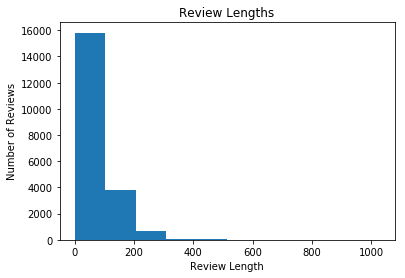

In [10]:
plt.hist(review_lengths)
plt.title('Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')

### Task 2

#### Clean the Corpus

In [52]:
# make reviews lowercase
lower_reviews = [review.lower() for review in all_reviews]

# remove punctuation
translator = str.maketrans('', '', string.punctuation)
no_punctuation = [review.translate(translator) for review in lower_reviews]

# remove non-verbose reviews
verbose = []
for review in no_punctuation:
    if len(review.split()) > 2:
        verbose.append(review)

In [53]:
# get canned english_stop words
english_stop = stopwords.words('english')

# join all reviews to find common words
combined_reviews = word_tokenize(' '.join(verbose))
word_freq = Counter(combined_reviews)

# find most common words
top_stop = word_freq.most_common(200)
stop_freq = [val[0] for val in top_stop]

# find least common words
stop_infreq = [key for key, value in word_freq.items() if value < 10]

# find doctors' last names
last = []
for i in doctors:
    split = i.split()
    last.append(split[-1].lower())
    
# remove numbers
numbers = [num for num in list(word_freq.keys()) if num.isdigit()]

# make all stop word list
stop_words = english_stop + stop_freq + stop_infreq + ["’"] + last + numbers

In [54]:
# Function to remove stop words from sentences & lemmatize verbs and nouns. 
def clean(doc, stop_words, lemmantize = False):
    # tokenize
    tokenized = word_tokenize(doc)
    # remove stop words
    result = [word for word in tokenized if word not in stop_words]
    # lemmantize condition
    if lemmantize:
        lemmatizer = WordNetLemmatizer()
        result = [lemmatizer.lemmatize(word,'v') for word in result]
        result = [lemmatizer.lemmatize(word,'n') for word in result]
        result = [s for s in result if len(s) > 2]
    return result

### Problem 1: No Lematization

In [55]:
# apply clean function to each review
corpus_clean = [clean(review.strip(), stop_words, False) for review in verbose]

# find a unique id for each unique term
dictionary = corpora.Dictionary(corpus_clean)

# convert tokenized documents into a document-term matrix
# structured (term ID, term frequency)
corpus = [dictionary.doc2bow(doc_clean) for doc_clean in corpus_clean]

# LDA model needs many iterations/passes and a large corpus to work well
# must define the number of topics you want to extract from the corpus
ldamodel = LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20, iterations=2000)

In [56]:
num_topics = 10
no_lem = []
for i in range(num_topics):
    tt = ldamodel.get_topic_terms(i,10)
    no_lem.append([dictionary[pair[0]] for pair in tt])

no_lem

[['son',
  'child',
  'baby',
  'daughter',
  'pregnancy',
  'children',
  'delivered',
  'pregnant',
  'old',
  'husband'],
 ['husband',
  'cancer',
  'breast',
  'hospital',
  'er',
  'knowledge',
  'top',
  'free',
  'area',
  'research'],
 ['amazing',
  'truly',
  'cares',
  'compassionate',
  'thank',
  'awesome',
  'everyone',
  'helped',
  'comfortable',
  'friends'],
 ['waiting',
  'phone',
  'hours',
  'hour',
  'appt',
  'waited',
  'calls',
  'exam',
  'front',
  'late'],
 ['thorough',
  'concerns',
  'listens',
  'health',
  'easy',
  'talk',
  'knowledgable',
  'things',
  'understand',
  'makes'],
 ['months',
  'saw',
  'second',
  'later',
  'weeks',
  'knee',
  'opinion',
  'year',
  'ago',
  'procedure'],
 ['worst',
  'money',
  'horrible',
  'wrong',
  'test',
  'pay',
  'bad',
  'unprofessional',
  'terrible',
  'nothing'],
 ['procedure',
  'skin',
  'look',
  'face',
  'removed',
  'foot',
  'body',
  'hip',
  'bad',
  'area'],
 ['medication',
  'diagnosed',
  'bloo

### Problem 2: Lemmatization

In [57]:
# apply clean function to each review
corpus_clean = [clean(review.strip(), stop_words, True) for review in verbose]

# find a unique id for each unique term
dictionary = corpora.Dictionary(corpus_clean)

# convert tokenized documents into a document-term matrix
# structured (term ID, term frequency)
corpus = [dictionary.doc2bow(doc_clean) for doc_clean in corpus_clean]

# filter out non-frequent words
new_corpus = []
for doc in corpus:
    new_list = []
    for word_count in doc:
        if word_count[1] > 3:
            new_list.append(word_count)
    new_corpus.append(new_list)

# LDA model needs many iterations/passes and a large corpus to work well
# must define the number of topics you want to extract from the corpus
ldamodel = LdaModel(new_corpus, num_topics=10, id2word = dictionary, passes=20, iterations=2000)

In [58]:
num_topics = 10
lem = []
for i in range(num_topics):
    tt = ldamodel.get_topic_terms(i,10)
    lem.append([dictionary[pair[0]] for pair in tt])
lem

[['doc',
  'cancer',
  'state',
  'month',
  'speak',
  'symptom',
  'phone',
  'lab',
  'record',
  'receive'],
 ['test',
  'eye',
  'come',
  'pap',
  'order',
  'script',
  'later',
  'lasik',
  'front',
  'side'],
 ['procedure',
  'breast',
  'implant',
  'follow',
  'explain',
  'able',
  'late',
  'code',
  'want',
  'infection'],
 ['daughter',
  'tooth',
  'exam',
  'baby',
  'decide',
  'money',
  'cavity',
  'routine',
  'therapy',
  'health'],
 ['mri',
  'dad',
  'vein',
  'specialist',
  'scar',
  'condition',
  'kid',
  'program',
  'comp',
  'ivf'],
 ['husband',
  'thyroid',
  'prescription',
  'seem',
  'leak',
  'tip',
  'ovary',
  'ear',
  'sister',
  'forget'],
 ['son',
  'bill',
  'child',
  'father',
  'wife',
  'nose',
  'hour',
  'give',
  'hand',
  'hip'],
 ['mother',
  'look',
  'clinic',
  'hospital',
  'refill',
  'cigna',
  'sign',
  'schedule',
  'colonoscopy',
  'book'],
 ['medication',
  'try',
  'start',
  'birth',
  'arm',
  'body',
  'psychiatrist',
  's